In [41]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Elaborazione immagini: 100%|██████████| 8492/8492 [00:04<00:00, 2047.46it/s]


(8476, 4096)
(8476,)


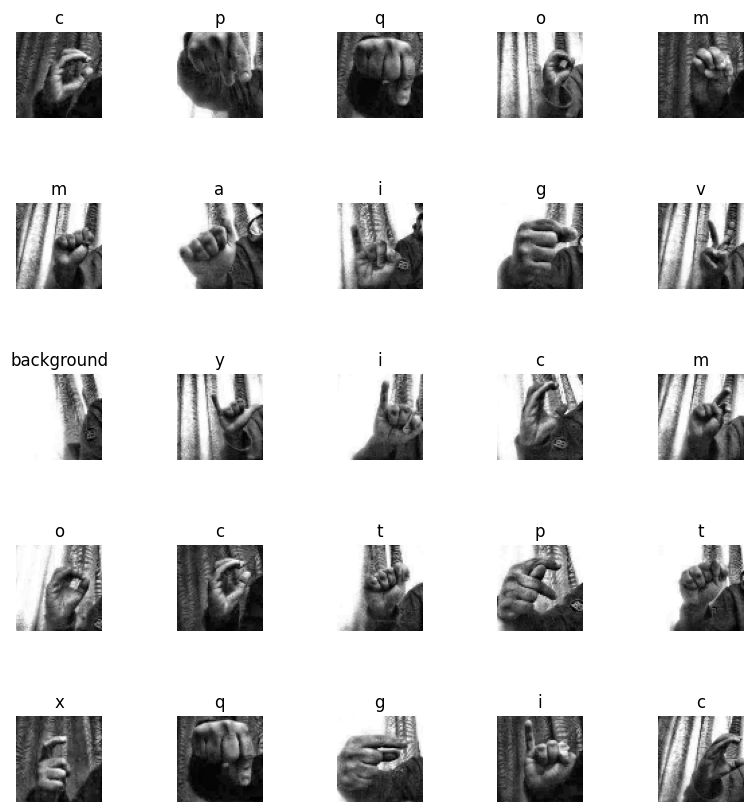

y = a: 380
y = b: 490
y = background: 460
y = c: 380
y = d: 290
y = e: 270
y = f: 340
y = g: 300
y = h: 350
y = i: 350
y = k: 360
y = l: 330
y = m: 610
y = n: 340
y = o: 370
y = p: 260
y = q: 180
y = r: 320
y = s: 230
y = t: 260
y = u: 329
y = v: 309
y = w: 319
y = x: 279
y = y: 370


In [42]:
def load_from_filenames(folder_path, img_size=64):
    features_list = []
    labels_list = []

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    # Lista tutti i file nella cartella
    all_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    for filename in tqdm(all_files, desc="Elaborazione immagini"):
        # 1. Estrazione Label: prendiamo tutto ciò che sta prima del primo '_'
        # Esempio: "background_a_1.png" -> "background"
        # Esempio: "a_v1.png" -> "a"
        label = filename.split('_')[0]
        
        # 2. Caricamento e Preprocessing
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
            
        img = cv2.resize(img, (img_size, img_size))
        feat = clahe.apply(img) # Bilancia l'esposizione
        
        features_list.append(feat.flatten())
        labels_list.append(label)
        
    return np.array(features_list), np.array(labels_list)


X, y = load_from_filenames("/home/mattia/Desktop/unige/ml2/machineLearning2_Assignment/training-a-robot-to-understand-sign-language/signlanguage/signlanguage")

# Utilizzo:
print(X.shape)
print(y.shape)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
i = 0
for ax in axs.reshape(-1):
  s = X[i,:]
  l = y[i]
  imm = np.reshape(s,(64,64))
  ax.imshow(imm, cmap='gray')
  ax.axis('off')
  ax.set_title(str(l))
  i = i + 1
plt.subplots_adjust(hspace=1)
plt.show()

for i in np.unique(y):
  print('y = ' + str(i) + ': ' + str(np.sum(y==i)))

Xl, Xt, yl, yt = train_test_split(X, y, test_size=0.75, random_state=11)

In [48]:
from sklearn.svm import LinearSVC

# Griglia per LinearSVC (usa 'C' come SVC, ma è molto più rapido)
grid = {'C': np.logspace(-6, 3, 10)}

M = GridSearchCV(estimator  = LinearSVC(dual=False), # dual=False è meglio quando n_samples > n_features
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'balanced_accuracy',
                 n_jobs     = 20)

M.fit(Xl, yl)

# Ora coef_ sarà (25, 4096)
best_model = M.best_estimator_
weights = best_model.coef_ 
print(f"Forma dei coefficienti: {weights.shape}") # Output atteso: (25, 4096)

Forma dei coefficienti: (25, 4096)


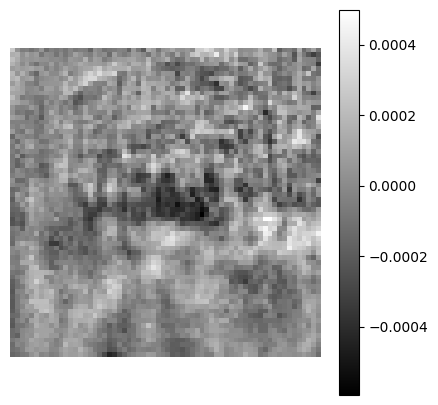

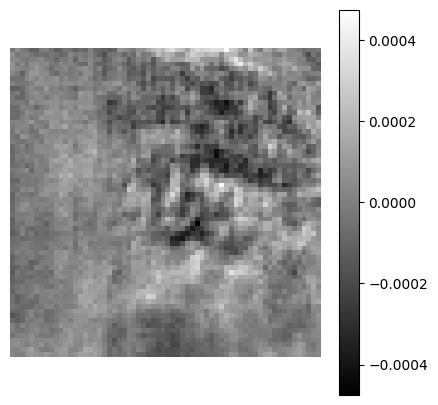

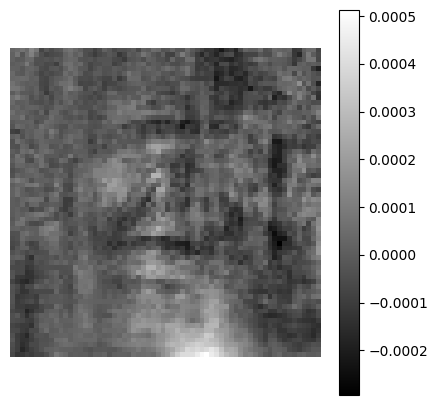

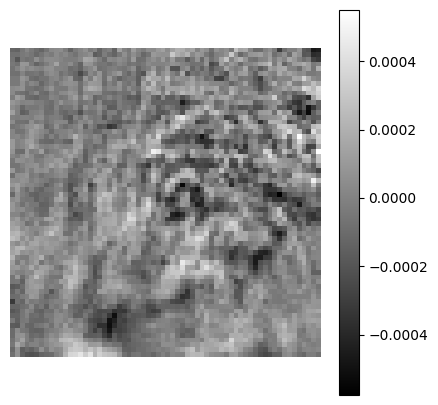

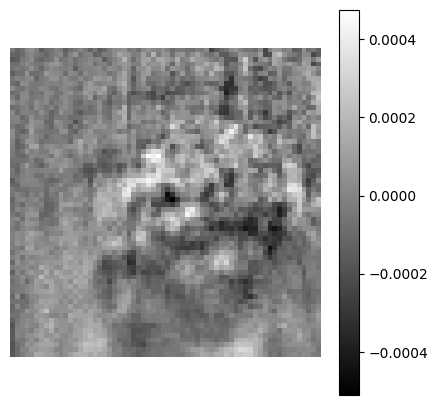

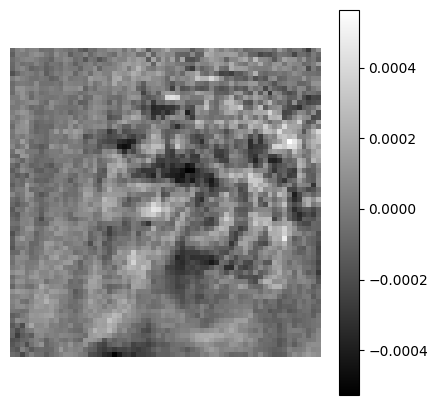

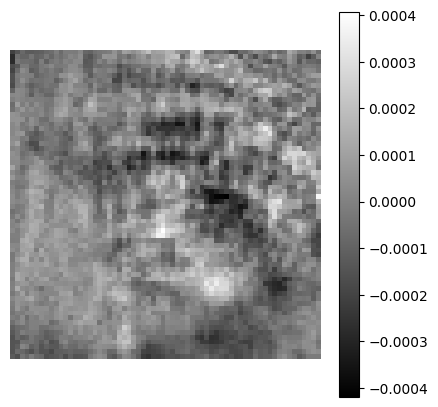

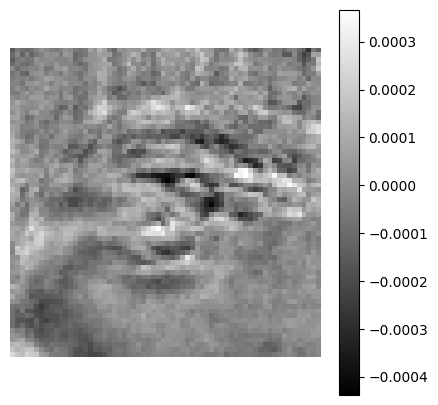

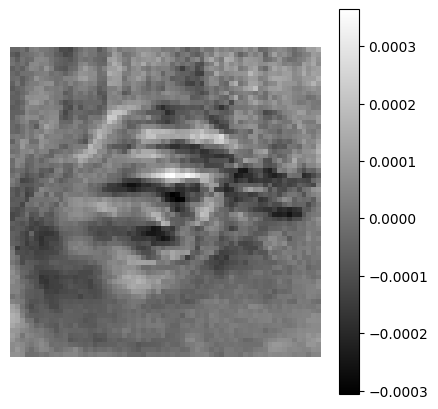

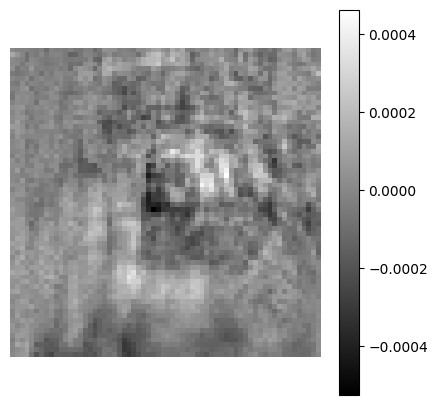

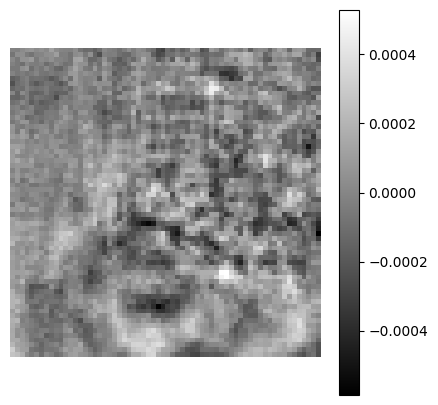

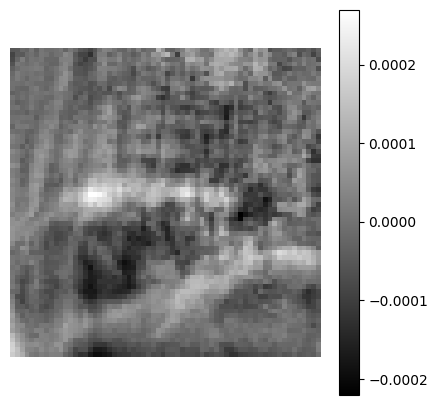

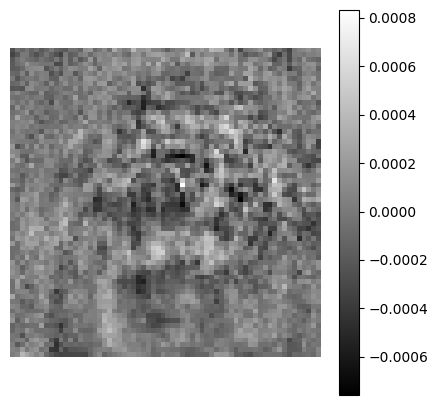

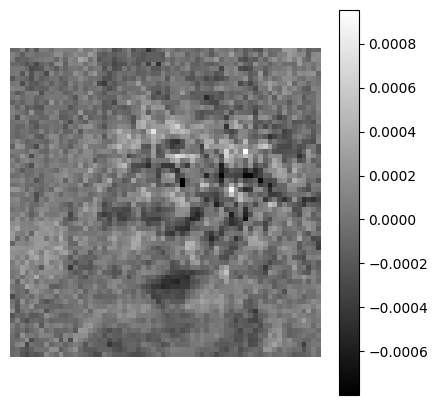

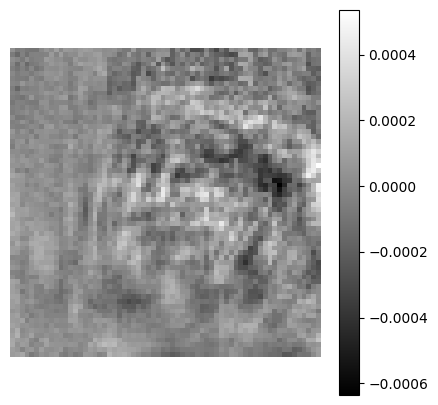

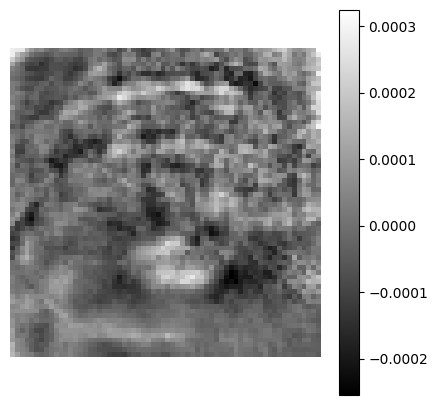

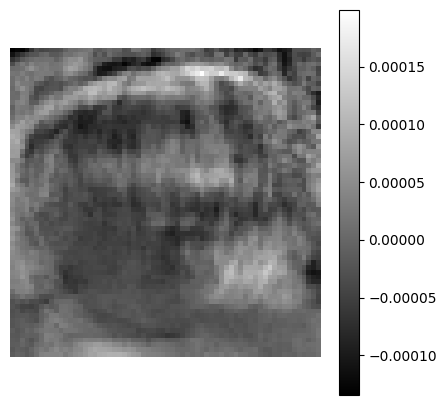

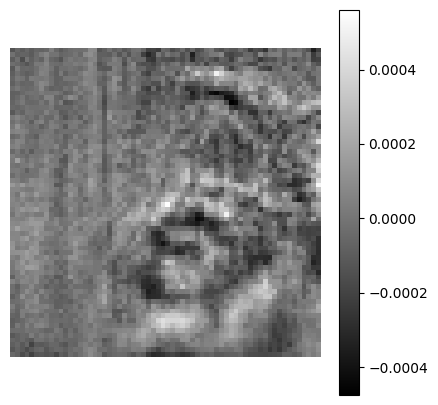

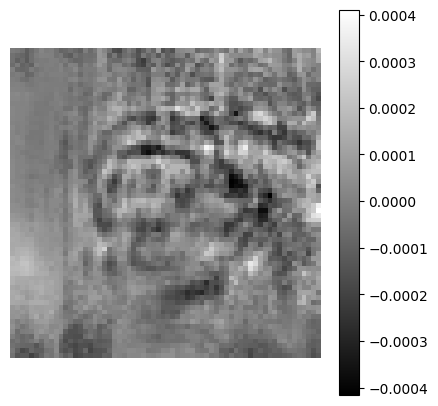

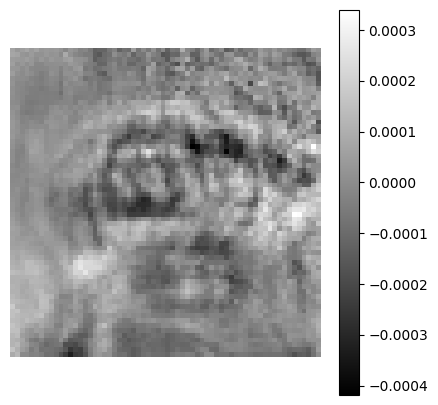

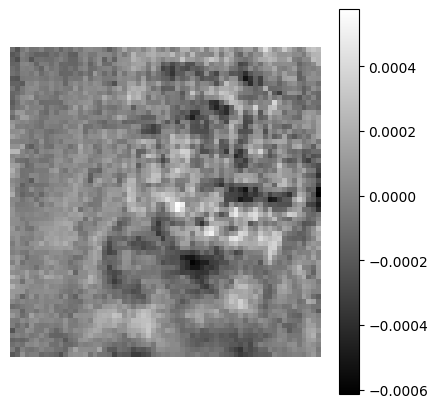

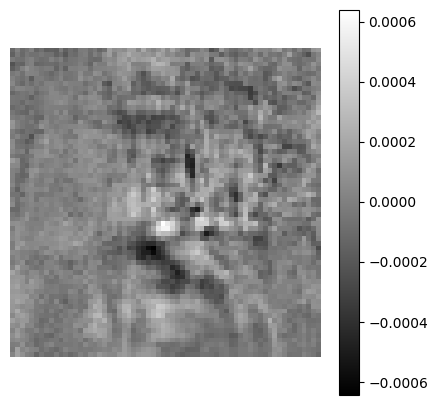

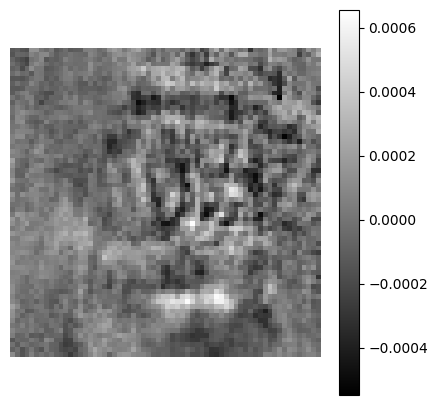

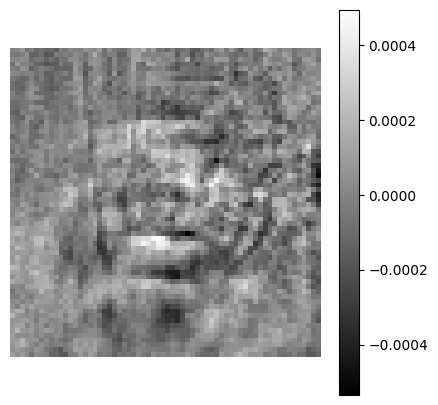

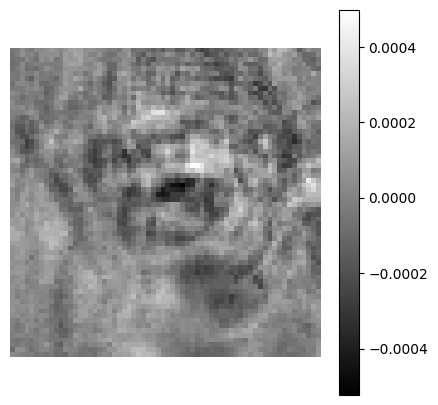

In [52]:
import matplotlib.pyplot as plt

w_best = M.best_estimator_
w = w_best.coef_
for i in range(len(w)):
    model = np.reshape(w[i],(64,64))
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(model, cmap='gray')
    ax.axis('off')
    fig.colorbar(im)
    plt.show()
